<div style="font-size:30px" align="center"> <b> Visualizing Word2Vec Models Trained on Biomedical Abstracts in PubMed </b> </div>
<div style="font-size:22px" align="center"> <b> A Comparison of Race and Diversity Over Time </b> </div>
<br>

<div style="font-size:18px" align="center"> <b> Brandon L. Kramer - University of Virginia's Bicomplexity Institute </b> </div>

<br>

This notebook explores two Word2Vec models trained the PubMed database taken from January 2021. Overall, I am interested in examining how diversity is used in biomedical abstracts and whether it is getting more closely to other kinds of diversity-related terms using Word2Vec. More specifically, I want to know whether Ellen Berry's argument that diversity is replacing race in conversations around structural inequality has legs in biomedicine. 

Before going too much further, those unfamiliar with Word2Vec may want to read [this post from Connor Gilroy](https://ccgilroy.github.io/community-discourse/introduction.html) - a sociologist that details how word embeddings can help us better understand the concept of "community." The post contains information on how Word2Vec and other word embedding approaches can teach us about word/document similarity, opposite words, and historical changes in words. Basically, Word2Vec turns all of the words in the corpus into a number based on how they are used in the context of 5-word windows (a parameter I defined while training my models model), making all of the words directly compariable to one another within a vector space. The end result is that we are able to compare how similar or different words are in each model. 

To compare how terms change relative to one another over time, I [trained](https://github.com/brandonleekramer/diversity/blob/master/src/04_word_embeddings/03_train_word2vec.ipynb) two models (one from 1990-1995 data and then a random sample of the 2015-2020 data to ensure the sample sizes are the same). Below, I share a function named `w2v_similarities_over_time()` that calculates the difference between all the words witin a dictionary of terms and then compares how they have changed relative to one another over time. Specifically, I will be comparing how diverse and diversity change relative to the terms in our race/ethnicity, sex/gender, social class, and cultural/equity categories from [Hypotheses 1 and 2](https://growthofdiversity.netlify.app/methods/). Then, I will visualize the results of these models comparisons using some heat maps. 

#### Import packages and ingest data 

First, let's load all of our packages and the `.bin` files that hold our models and also the dictionary of all the terms we want to compare. 

In [1]:
# load packages
import os
from itertools import product
import pandas.io.sql as psql
import pandas as pd
from pandas import DataFrame
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import seaborn as sns

# load pretrained word embeddings models  
os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/word_embeddings/")
early_model = Word2Vec.load("word2vec_1990_2000.bin")
later_model = Word2Vec.load("word2vec_2010_2020.bin")

The dictionary that we want to import is the same one that we used to test Hypothesis 1 and Hypothesis 2, which means that we have ~450 distinct terms. Creating a matrix that compared all these terms to each other is massive, so let's create four subdictionaries with the terms we are most interested. 

In [44]:
# load dictionary of words 
os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/dictionaries/")
h1_dictionary = pd.read_csv("diversity_project - tree_data.csv")
h1_dictionary = h1_dictionary[h1_dictionary['embeddings'] == 1].drop(['hypothesis', 'embeddings'], axis=1)
h1_dictionary = h1_dictionary.replace({'category': {'asian|black|hispanic_latinx|white': 'race_ethnicity'}}, regex=True)
h1_dictionary = h1_dictionary.replace({'category': {'sex_gender|sexuality': 'gender_sexuality'}}, regex=True)
h1_dictionary = h1_dictionary.replace({'category': {'cultural|equity': 'cultural_equity'}}, regex=True)
h1_dictionary = h1_dictionary.replace({'category': {'minority': 'social_class'}}, regex=True).sort_values(by=['category', 'term'])
h1_dictionary = h1_dictionary.replace({'term': {'under_served': 'underserved'}}, regex=True).sort_values(by=['category', 'term'])
h1_dictionary.head()

,category,term
0,cultural_equity,cultural
61,cultural_equity,disparity
65,cultural_equity,equality
63,cultural_equity,equity
68,cultural_equity,inequality


In [19]:
def w2v_similarities_over_time(df, w2v_m1, w2v_m2):
    ''' 
    function compares several word2vec vectors from two different years 
    and then examines how those several comparisons change over time  
    ----------------------------------------------------------------
    1) first it takes a dictionary of words and creates its product
    2) compares all of those words within the vector space of w2v_m1
    3) compares all of those words within the vector space of w2v_m2
    4) examines changes in the comparisons of w2v_m1 and w2v_m2 over time 
    
    '''
    df = list(product(df['term'], df['term']))
    df = pd.DataFrame(df, columns=['term1','term2'])
    
    cos_sim_m1 = []
    for index, row in df.iterrows():
        cos_sim_m1.append(w2v_m1.wv.similarity(row[0],row[1]))
    cos_sim_m1 = DataFrame(cos_sim_m1, columns=['cos_sim_m1'])
    df = df.merge(cos_sim_m1, left_index=True, right_index=True) 
    
    cos_sim_m2 = []
    for index, row in df.iterrows():
        cos_sim_m2.append(w2v_m2.wv.similarity(row[0],row[1]))
    cos_sim_m2 = DataFrame(cos_sim_m2, columns=['cos_sim_m2'])
    df = df.merge(cos_sim_m2, left_index=True, right_index=True)
    df["cos_sim_diffs"] = df["cos_sim_m1"] - df["cos_sim_m2"]
    
    df_matrix = df.pivot("term1", "term2", "cos_sim_diffs")
    return df_matrix

Cultural Comparisons 

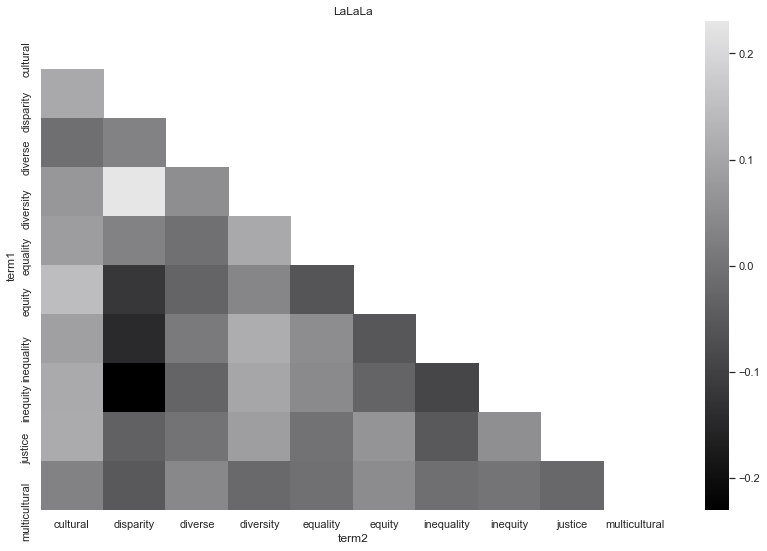

In [38]:
cultural_equity = h1_dictionary[(h1_dictionary['category'] == 'cultural_equity') | 
                                (h1_dictionary['category'] == 'diversity')]
cultural_equity_matrix = w2v_similarities_over_time(cultural_equity, early_model, later_model)
#cmap = sns.diverging_palette(20, 230, as_cmap=True)
cmap = sns.cubehelix_palette(200, hue=0.05, rot=0, light=0, dark=0.9)
corr_cultural = cultural_equity_matrix.corr()
mask_cultural = np.triu(np.ones_like(corr_cultural, dtype=bool))
cultural_equity_heatmap = sns.heatmap(cultural_equity_matrix, mask=mask_cultural, cmap=cmap).set_title("Figure 4A. Cultural and Equity/Justice Vectors")
#cultural_equity_matrix

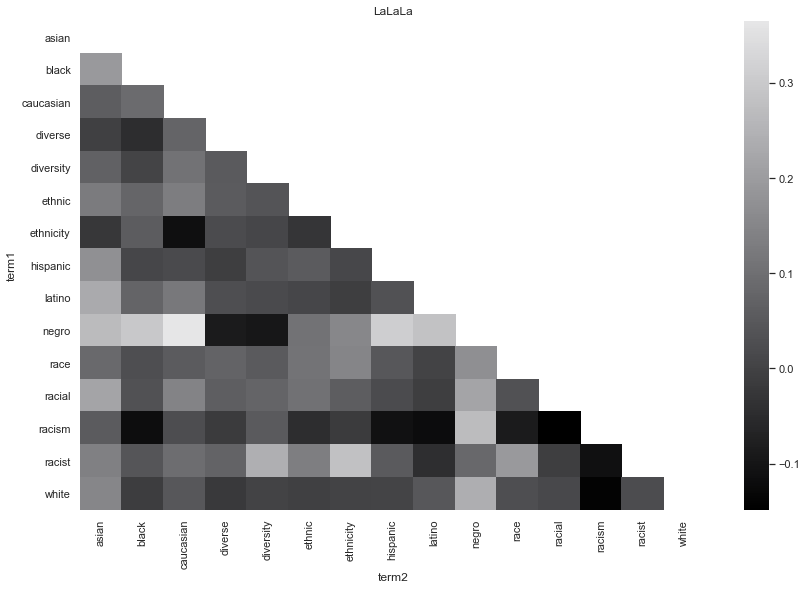

In [39]:
race_ethnicity = h1_dictionary[(h1_dictionary['category'] == 'race_ethnicity') | 
                               (h1_dictionary['category'] == 'diversity')]
race_ethnicity_matrix = w2v_similarities_over_time(race_ethnicity, early_model, later_model)
corr_race = race_ethnicity_matrix.corr()
mask_race = np.triu(np.ones_like(corr_race, dtype=bool))
race_ethnicity_heatmap = sns.heatmap(race_ethnicity_matrix, mask=mask_race, cmap=cmap).set_title("Figure 4B. Racial and Ethnic Vectors")
#race_ethnicity_matrix

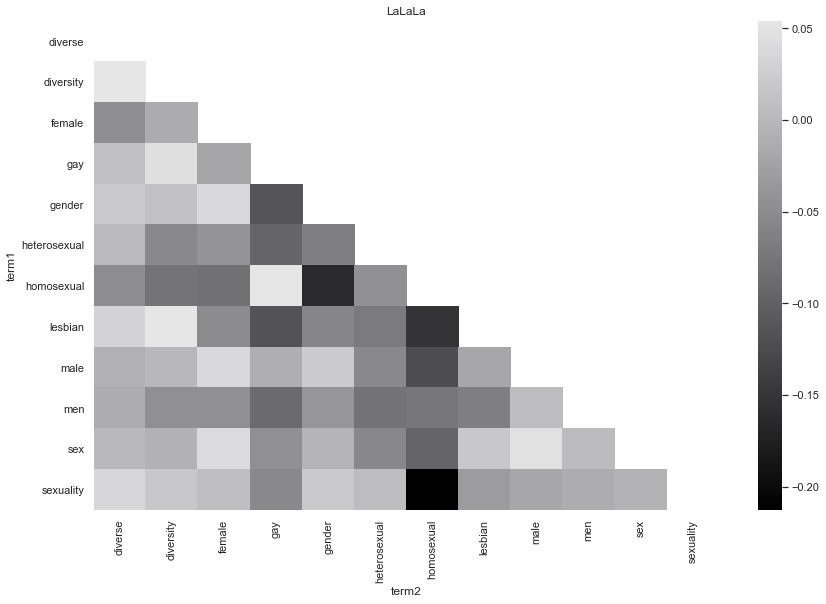

In [40]:
gender_sexuality = h1_dictionary[(h1_dictionary['category'] == 'gender_sexuality') | 
                                 (h1_dictionary['category'] == 'diversity')]
gender_sexuality = gender_sexuality[gender_sexuality.term != 'women']
gender_sexuality_matrix = w2v_similarities_over_time(gender_sexuality, early_model, later_model)
corr_gender = gender_sexuality_matrix.corr()
mask_gender = np.triu(np.ones_like(corr_gender, dtype=bool))
gender_sexuality_heatmap = sns.heatmap(gender_sexuality_matrix, mask=mask_gender, cmap=cmap).set_title("Figure 4C. Gender and Sexuality Vectors")
#gender_sexuality_matrix

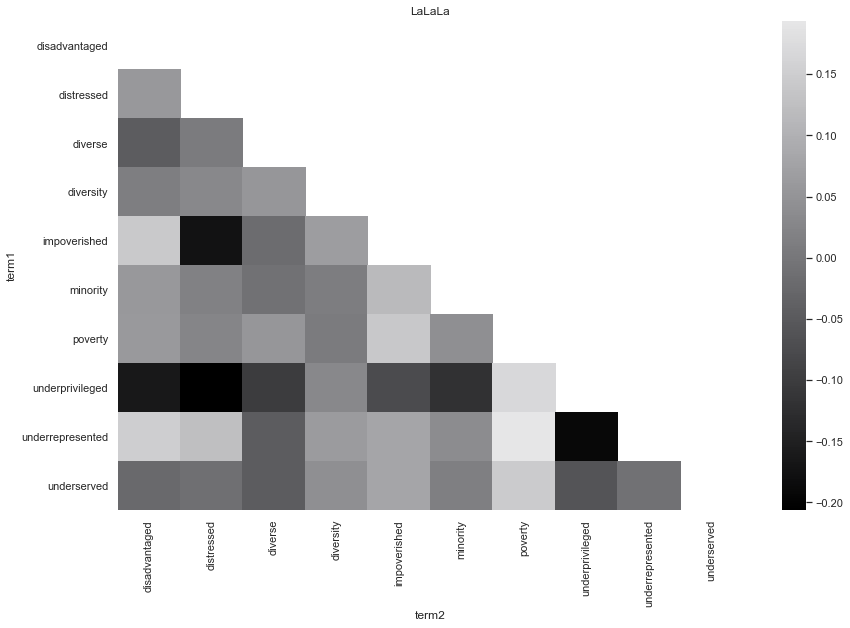

In [42]:
social_class = h1_dictionary[(h1_dictionary['category'] == 'social_class') | 
                             (h1_dictionary['category'] == 'diversity')]
social_class_matrix = w2v_similarities_over_time(social_class, early_model, later_model)
corr_class = social_class_matrix.corr()
mask_class = np.triu(np.ones_like(corr_class, dtype=bool))
social_class_heatmap = sns.heatmap(social_class_matrix, mask=mask_class, cmap=cmap).set_title("Figure 4D. Socio-Economic Vectors")
#social_class_matrix

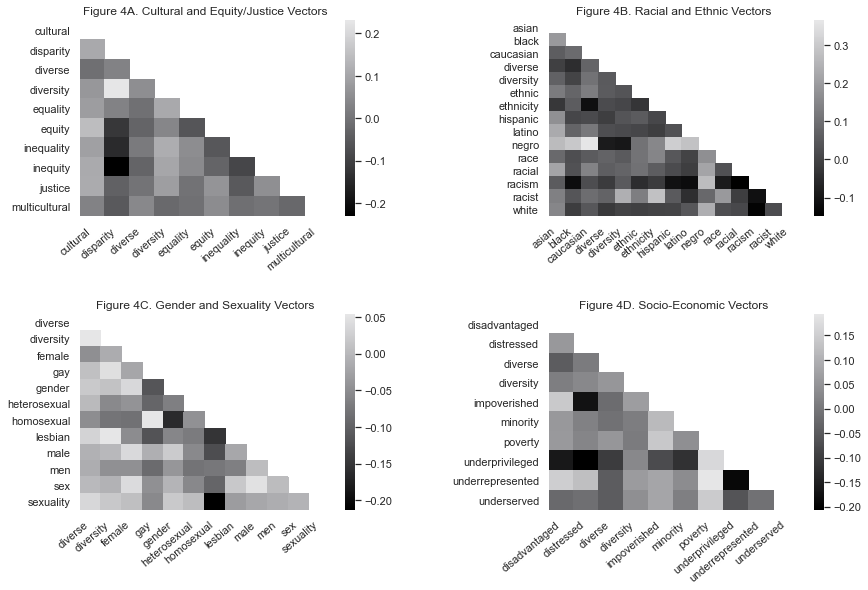

In [43]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(14,9)})
sns.set_style("whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=False)
cultural_equity_g = sns.heatmap(cultural_equity_matrix, mask=mask_cultural, cmap=cmap, ax=ax1)
cultural_equity_g.set_title("Figure 4A. Cultural and Equity/Justice Vectors")
cultural_equity_g.set(xlabel=None)
cultural_equity_g.set(ylabel=None)
cultural_equity_g.set_xticklabels(cultural_equity_g.get_xticklabels(), rotation=40, horizontalalignment='right')
race_ethnicity_g = sns.heatmap(race_ethnicity_matrix, mask=mask_race, cmap=cmap, ax=ax2)
race_ethnicity_g.set_title("Figure 4B. Racial and Ethnic Vectors")
race_ethnicity_g.set(xlabel=None)
race_ethnicity_g.set(ylabel=None)
race_ethnicity_g.set_xticklabels(race_ethnicity_g.get_xticklabels(), rotation=40, horizontalalignment='right')
gender_sexuality_g = sns.heatmap(gender_sexuality_matrix, mask=mask_gender, cmap=cmap, ax=ax3)
gender_sexuality_g.set_title("Figure 4C. Gender and Sexuality Vectors")
gender_sexuality_g.set(xlabel=None)
gender_sexuality_g.set(ylabel=None)
gender_sexuality_g.set_xticklabels(gender_sexuality_g.get_xticklabels(), rotation=40, horizontalalignment='right')
social_class_g = sns.heatmap(social_class_matrix, mask=mask_class, cmap=cmap, ax=ax4)
social_class_g.set_title("Figure 4D. Socio-Economic Vectors")
social_class_g.set(xlabel=None)
social_class_g.set(ylabel=None)
social_class_g.set_xticklabels(social_class_g.get_xticklabels(), rotation=40, horizontalalignment='right')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

In [ ]:
earlier_model.save('vectors.kv')
reloaded_word_vectors = KeyedVectors.load('vectors.kv')

#### Analyzing Most Similar Words 

**What words are most similar to "racial" and "diversity"?** As we can see below, "racial" is mostly similar to other racialized and/or gendered terms in both the 1990-95 and 2015-20 periods. "Diversity", on the other hand, is most similar to heterogeneity, divergence and complexity in 1990-95 and then richness, divergence and diversification in 2015-20. Overall, this tells us a different version of the same story we saw when analyzing Hypothesis 1: "diversity" rarely refers to social diversity along racial or classed lines. Diversity is mostly used as a biological term. Even here, richness, along with evenness, are measure within Simpson's Index for measuring ecological biodiversity (e.g. [Stirling et al. 2001](https://www.journals.uchicago.edu/doi/abs/10.1086/321317?casa_token=Fb4sojZm9XgAAAAA:BV-t4e5f3SZ05gTJZRUydcQvHTYg47f1qRu51CixgF-b_HnGVXuPQFaqf_Lp88Tvy51Gnp7iw4yG)). 

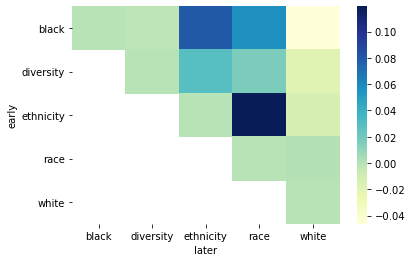

In [96]:
from dataclasses import make_dataclass
df = make_dataclass("Point", [("early", str), ("later", str), ("difference", int)])
df = pd.DataFrame([df("black", "black", em.wv.similarity('black','black')-lm.wv.similarity('black','black')),
                   df("diversity", "diversity", em.wv.similarity('diversity','diversity')-lm.wv.similarity('diversity','diversity')),
                   df("ethnicity", "ethnicity", em.wv.similarity('ethnicity','ethnicity')-lm.wv.similarity('ethnicity','ethnicity')),
                   df("race", "race", em.wv.similarity('race','race')-lm.wv.similarity('race','race')),
                   df("white", "white", em.wv.similarity('white','white')-lm.wv.similarity('white','white')),
                   df("black", "diversity", em.wv.similarity('black','diversity')-lm.wv.similarity('black','diversity')), 
                   df("black", "white", em.wv.similarity('black','white')-lm.wv.similarity('black','white')), 
                   df("black", "ethnicity", em.wv.similarity('black','ethnicity')-lm.wv.similarity('black','ethnicity')),
                   df("black", "race", em.wv.similarity('black','race')-lm.wv.similarity('black','race')),
                   df("diversity", "ethnicity", em.wv.similarity('diversity','ethnicity')-lm.wv.similarity('diversity','ethnicity')),
                   df("diversity", "race", em.wv.similarity('diversity','race')-lm.wv.similarity('diversity','race')), 
                   df("diversity", "white", em.wv.similarity('diversity','white')-lm.wv.similarity('diversity','white')),  
                   df("ethnicity", "race", em.wv.similarity('ethnicity','race')-lm.wv.similarity('ethnicity','race')),
                   df("ethnicity", "white", em.wv.similarity('ethnicity','white')-lm.wv.similarity('ethnicity','white')),
                   df("race", "white", em.wv.similarity('race','white')-lm.wv.similarity('race','white'))
                  ])
df = df.sort_values(by=['early']).pivot("early", "later", "difference")
ax = sns.heatmap(df, cmap="YlGnBu")

In [ ]:
earlier_model.wv.get_vector('gender')

Text(0.5, 1.0, 'Similar to racial in 1990-95:')

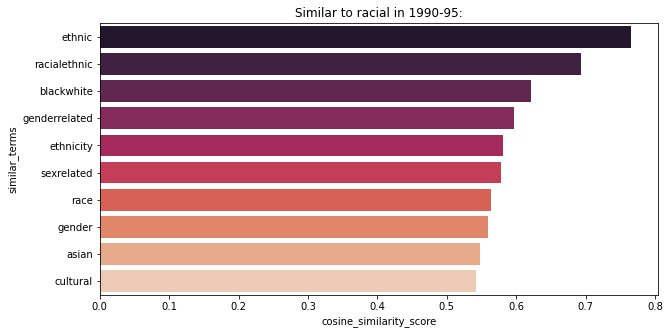

In [20]:
racial_sim_early = earlier_model.wv.most_similar('racial')
racial_sim_early = pd.DataFrame(data=racial_sim_early).rename(columns={0: "similar_terms", 
                                                                       1: "cosine_similarity_score"})
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="cosine_similarity_score", y="similar_terms", 
            data=racial_sim_early, palette="rocket", 
            ax=ax).set_title('Similar to racial in 1990-95:')

Text(0.5, 1.0, 'Similar to racial in 2015-20:')

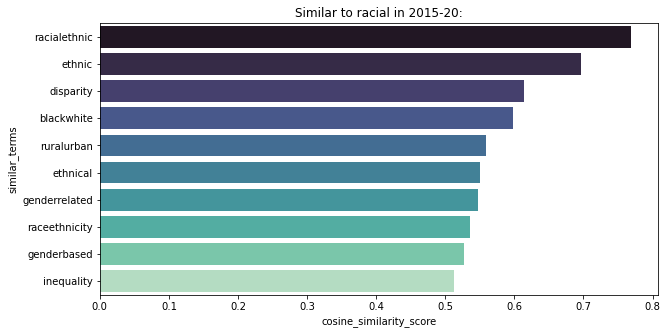

In [66]:
racial_sim_later = later_model.wv.most_similar('racial')
racial_sim_later = pd.DataFrame(data=racial_sim_later).rename(columns={0: "similar_terms", 
                                                                       1: "cosine_similarity_score"})
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="cosine_similarity_score", y="similar_terms", 
            data=racial_sim_later, palette="mako", 
            ax=ax).set_title('Similar to racial in 2015-20:')

Text(0.5, 1.0, 'Similar to diversity in 1990-95:')

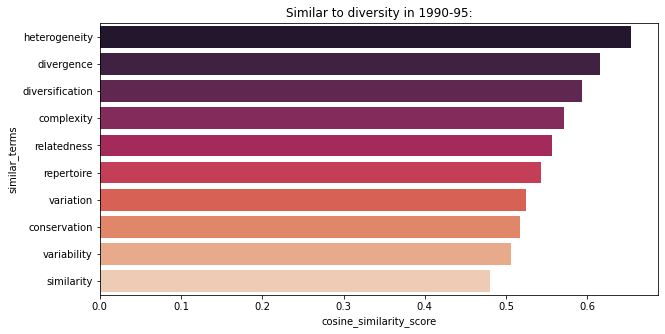

In [67]:
diversity_sim_earlier = earlier_model.wv.most_similar('diversity')
diversity_sim_earlier = pd.DataFrame(data=diversity_sim_earlier).rename(columns={0: "similar_terms", 
                                                                                 1: "cosine_similarity_score"})
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="cosine_similarity_score", y="similar_terms", 
            data=diversity_sim_earlier, palette="rocket", 
            ax=ax).set_title('Similar to diversity in 1990-95:')

Text(0.5, 1.0, 'Similar to diversity in 2015-20:')

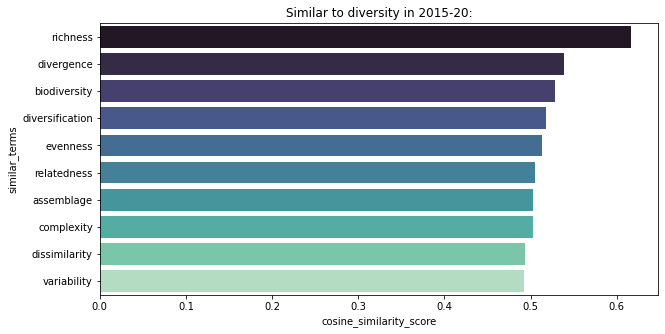

In [68]:
diversity_sim_later = later_model.wv.most_similar('diversity')
diversity_sim_later = pd.DataFrame(data=diversity_sim_later).rename(columns={0: "similar_terms", 
                                                                             1: "cosine_similarity_score"})
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="cosine_similarity_score", y="similar_terms", 
            data=diversity_sim_later, palette="mako", 
            ax=ax).set_title('Similar to diversity in 2015-20:')

#### Comparing Race and Diversity 

That makes it a little difficult to directly compare the terms, so let's use the `wv.similarity()` function to directly look at that. This basically allows you to directly compare the two words to see how close they are in the vector space.

In [21]:
race_diversity_early = earlier_model.wv.similarity('race','diversity')
race_diversity_later = later_model.wv.similarity('race','diversity')
racial_diversity_early = earlier_model.wv.similarity('racial','diversity')
racial_diversity_later = later_model.wv.similarity('racial','diversity')
ethnic_diversity_early = earlier_model.wv.similarity('ethnic','diversity')
ethnic_diversity_later = later_model.wv.similarity('ethnic','diversity')
ethnicity_diversity_early = earlier_model.wv.similarity('ethnicity','diversity')
ethnicity_diversity_later = later_model.wv.similarity('ethnicity','diversity')
race_diverse_early = earlier_model.wv.similarity('race','diverse')
race_diverse_later = later_model.wv.similarity('race','diverse')
racial_diverse_early = earlier_model.wv.similarity('racial','diverse')
racial_diverse_later = later_model.wv.similarity('racial','diverse')
ethnic_diverse_early = earlier_model.wv.similarity('ethnic','diverse')
ethnic_diverse_later = later_model.wv.similarity('ethnic','diverse')
ethnicity_diverse_early = earlier_model.wv.similarity('ethnicity','diverse')
ethnicity_diverse_later = later_model.wv.similarity('ethnicity','diverse')

print('Overall Comparisons of Racial and Diversity Terms:')
print('Race and diversity:      1990-1995 score:', race_diversity_early, ' 2015-2020 score:', race_diversity_later, ' Difference is:', race_diversity_later-race_diversity_early )
print('Racial and diversity:    1990-1995 score:', racial_diversity_early, ' 2015-2020 score:', racial_diversity_later, ' Difference is:', racial_diversity_later-racial_diversity_early)
print('Ethnic and diversity:    1990-1995 score:', ethnic_diversity_early, ' 2015-2020 score:', ethnic_diversity_later, ' Difference is:', ethnic_diversity_later-ethnic_diversity_early)
print('Ethnicity and diversity: 1990-1995 score:', ethnicity_diversity_early, ' 2015-2020 score:', ethnicity_diversity_later, ' Difference is:', ethnicity_diversity_later-ethnicity_diversity_early)
print('Race and diverse:        1990-1995 score:', race_diverse_early, ' 2015-2020 score:', race_diverse_later, ' Difference is:', race_diverse_later-race_diverse_early)
print('Racial and diverse:      1990-1995 score:', racial_diverse_early, '  2015-2020 score:', racial_diverse_later, ' Difference is:', racial_diverse_later-racial_diverse_early)
print('Ethnic and diverse:      1990-1995 score:', ethnic_diverse_early, ' 2015-2020 score:', ethnic_diverse_later, ' Difference is:', ethnic_diverse_later-ethnic_diverse_early)
print('Ethnicity and diverse:   1990-1995 score:', ethnicity_diverse_early, ' 2015-2020 score:', ethnicity_diverse_later, '  Difference is:', ethnicity_diverse_later-ethnicity_diverse_early)

Overall Comparisons of Racial and Diversity Terms:
Race and diversity:      1990-1995 score: 0.10367876  2015-2020 score: 0.08713666  Difference is: -0.0165421
Racial and diversity:    1990-1995 score: 0.22878885  2015-2020 score: 0.19454905  Difference is: -0.0342398
Ethnic and diversity:    1990-1995 score: 0.26469263  2015-2020 score: 0.24086899  Difference is: -0.023823649
Ethnicity and diversity: 1990-1995 score: 0.17010239  2015-2020 score: 0.14082599  Difference is: -0.0292764
Race and diverse:        1990-1995 score: 0.10392621  2015-2020 score: 0.09927894  Difference is: -0.00464727
Racial and diverse:      1990-1995 score: 0.1746344   2015-2020 score: 0.14384314  Difference is: -0.030791253
Ethnic and diverse:      1990-1995 score: 0.31651908  2015-2020 score: 0.22292474  Difference is: -0.09359434
Ethnicity and diverse:   1990-1995 score: 0.14617169  2015-2020 score: 0.0965081   Difference is: -0.04966359


To interpret these scores, we have to know that a value of 1 means that two words have a perfect relationship, 0 means the two words have no relationship, and -1 means that they are perfect opposites ([Stack Overflow 2017](https://stackoverflow.com/questions/42381902/interpreting-negative-word2vec-similarity-from-gensim), [Google Groups 2019](https://groups.google.com/g/gensim/c/SZ1yct-7CuU)). Thus, when we compare all of the race, racial, ethnic and ethnicity vectors to diverse and diversity, we actually see that they are becoming *less* similar over time. Thus, despite our earlier hypotheses indicating that diversity is rising while racial terms decline, it does not seem to be the case that the two are being used in similar ways over time. It is worth noting that a number of things could complicate this interpretation, including the polysemy of diversity. Before moving on to plots of these vectors, let's take a look at specific racial terms and see how they compare to diversity. 

Overall, this approach gave us some mixed results. Asian and diversity/diverse become significantly more dissimilar while white and diversity/diverse become more similar. Once could argue that this supports Berrey's argument about diversity being used to reinforce whiteness, but it also might just be diverse/diversity being more to describe variation in neuroscience where a common term is 'white matter.' In the end, it might just be the case that the Word2Vec model's inability to deal with polysemy does not help us answer our research question. Before concluding that, let's look at visual plots of our vectors. 

#### Singular Value Decomposition 

In order to do that, we have to reduce the 512 dimension model into just 2 dimensions using the `TSNE` package. We will do this for both models, which will take around 30 minutes to run. Scroll down to see the results...

In [109]:
%%capture
earlier_vocab = list(earlier_model.wv.vocab)
earlier_x = earlier_model[earlier_vocab]
earlier_tsne = TSNE(n_components=2)
earlier_tsne_x = earlier_tsne.fit_transform(earlier_x)
df_earlier = pd.DataFrame(earlier_tsne_x, index=earlier_vocab, columns=['x', 'y'])

later_vocab = list(later_model.wv.vocab)
later_x = later_model[later_vocab]
later_tsne = TSNE(n_components=2)
later_tsne_x = later_tsne.fit_transform(later_x)
df_later = pd.DataFrame(later_tsne_x, index=later_vocab, columns=['x', 'y'])

keys = ['race', 'racial', 'ethnic', 'ethnicity', 'diverse', 'diversity']

earlier_embedding_clusters = []
earlier_word_clusters = []
for word in keys:
    earlier_embeddings = []
    earlier_words = []
    for similar_word, _ in earlier_model.wv.most_similar(word, topn=30):
        earlier_words.append(similar_word)
        earlier_embeddings.append(earlier_model[similar_word])
    earlier_embedding_clusters.append(earlier_embeddings)
    earlier_word_clusters.append(earlier_words)
    
earlier_embedding_clusters = np.array(earlier_embedding_clusters)
n, m, k = earlier_embedding_clusters.shape
e_tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
e_embeddings_en_2d = np.array(e_tsne_model_en_2d.fit_transform(earlier_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

later_embedding_clusters = []
later_word_clusters = []
for word in keys:
    later_embeddings = []
    later_words = []
    for similar_word, _ in later_model.wv.most_similar(word, topn=30):
        later_words.append(similar_word)
        later_embeddings.append(later_model[similar_word])
    later_embedding_clusters.append(later_embeddings)
    later_word_clusters.append(later_words)
    
later_embedding_clusters = np.array(later_embedding_clusters)
n, m, k = later_embedding_clusters.shape
l_tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
l_embeddings_en_2d = np.array(l_tsne_model_en_2d.fit_transform(later_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

#### Plotting the Results of the Word2Vec Models (1990-95 vs 2015-20)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

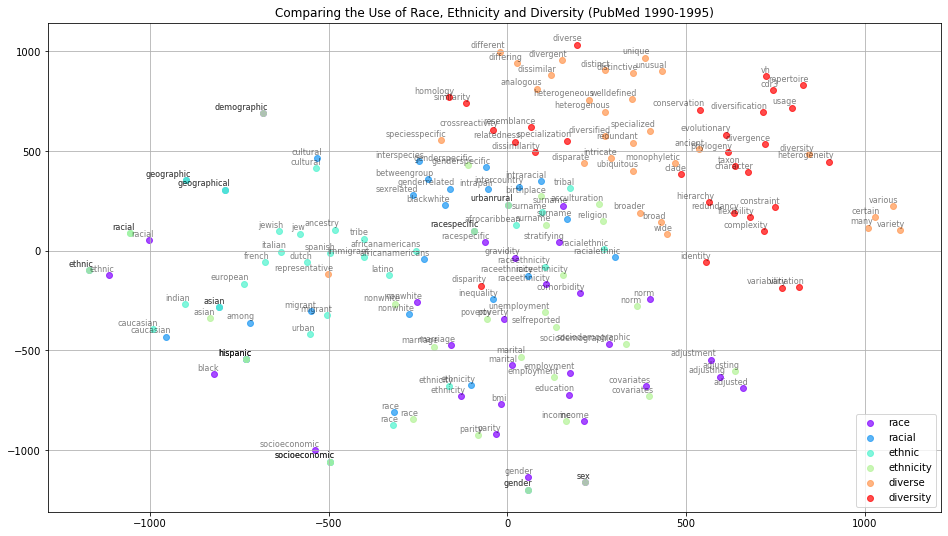

<Figure size 432x288 with 0 Axes>

In [136]:
def tsne_plot_similar_words(title, labels, earlier_embedding_clusters, earlier_word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, earlier_embeddings, earlier_words, color in zip(labels, earlier_embedding_clusters, earlier_word_clusters, colors):
        x = earlier_embeddings[:, 0]
        y = earlier_embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(earlier_words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


early_plot = tsne_plot_similar_words('Comparing the Use of Race, Ethnicity and Diversity (PubMed 1990-1995)', 
                        keys, e_embeddings_en_2d, earlier_word_clusters, 
                        0.7, 'earlier_comparison.png')

os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/word_embeddings/")
plt.savefig('earlier_comparison.png')
early_plot

Now we can look at how the words in each vector of race, racial, ethnic, ethnicity, diversity and diverse. When we start to look at the specific terms of interest, we find racial and ethnic are the far left or toward the bottom-center. Other variants of these terms are more centered in the plot. On the other hand, diversity and diverse are both clustered toward the top-right, which means that race and diversity are fairly far away in the vector space.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

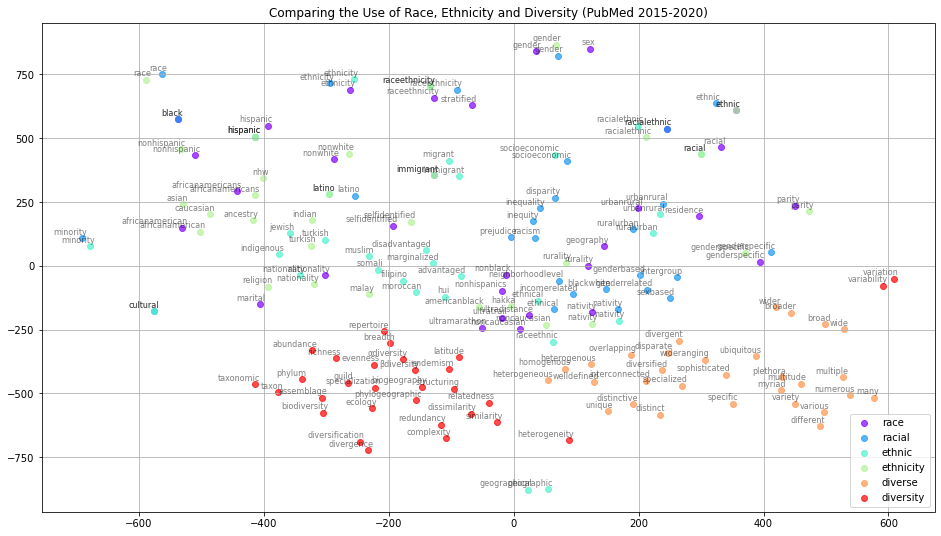

<Figure size 432x288 with 0 Axes>

In [138]:
def tsne_plot_similar_words(title, labels, later_embedding_clusters, later_word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, later_embeddings, later_words, color in zip(labels, later_embedding_clusters, later_word_clusters, colors):
        x = later_embeddings[:, 0]
        y = later_embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(later_words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


later_plot = tsne_plot_similar_words('Comparing the Use of Race, Ethnicity and Diversity (PubMed 2015-2020)', 
                        keys, l_embeddings_en_2d, later_word_clusters, 
                        0.7, 'later_comparison.png')

os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/word_embeddings/")
plt.savefig('later_comparison.png')
later_plot

When we look at the same vectors in the 2015-20 model, it seems like the vectors are more closely related overall. However, when we look closer we see that the 'race' and 'ethnicity' are up in the top-left corner while 'racial' and 'ethnic' are in the top-right corner. Both sets are still fairly separated from the red and orange diversity vectors. Although these plots do not show this as clear as one might want, our analyses above do suggest that diverse and diversity as well as race, racial, ethnic, and ethinicity are being used more dissimilarly over time. The challenging thing about this analysis disentangling the polysemy from how diversity is used. If we were able to 'disentange' the use of diveristy in its more general sense compared to its usage in the context of equity, inclusion and justice discussions, would we find that the two words are becoming more similar over time? The answer likely resides in a model other than Word2Vec such as BERT or ELMo ([Fonteyn 2019](https://laurenthelinguist.files.wordpress.com/2019/08/sle_2019_bert.pdf); [Rakhmanberdieva 2019](https://towardsdatascience.com/word-representation-in-natural-language-processing-part-iii-2e69346007f)). 

#### References

[Connor Gilroy's Tutorial](https://ccgilroy.github.io/community-discourse/word-similarity.html)

[Dominiek Ter Heide's Word2Vec Explorer](https://github.com/dominiek/word2vec-explorer)

[Sergey Smetanin's Medium Tutorial](https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d)

[Guru 99's Tutorial on Word Embeddings](https://www.guru99.com/word-embedding-word2vec.html)

[Rakhmanberdieva's 2019 Medium Post](https://towardsdatascience.com/word-representation-in-natural-language-processing-part-iii-2e69346007f)

[Fonteyn's 2019 Presentation](https://laurenthelinguist.files.wordpress.com/2019/08/sle_2019_bert.pdf)

[Bagheri's Medium Post on SVD](https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d)